In [58]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

CUSTOM_FORMAT = {"with_labels" : False,
                "node_size": 10, "node_color": "red", "edgecolors": "black",
                "linewidths": 0.25, "width": 0.25, "edge_color": "black"}

plt.style.use("seaborn")


# 1) Red Erdos Renyi $G(N, p)$

In [ ]:
N = 10_000
m = 50_000

def erdos_renyi_graph(N: int, p: float) -> nx.Graph:
    random_matrix = np.random.random((N, N)) #Matriz de NxN de numeros aleatorios del 0 al 1.
    #Si el valor obtenido es menor que p, nos quedamos.
    threshold = np.where(random_matrix < p, 1, 0) #Para un valor de p-pequeño: "Era poco probable, pero pasó."

    #Nos quedamos con la parte superior, la transpuesta de la misma, y la diagonal para armar una A simétrica.
    A = np.triu(threshold, 1) + np.triu(threshold, 1).T
    return nx.from_numpy_array(A)


def erdos_renyi_m(N: int, approx_m: int) -> nx.Graph:
    p = 2*approx_m/(N*(N-1))
    return erdos_renyi_graph(N, p)


G_list = []
for i in range(100):
    G_list.append(erdos_renyi_m(N, m))
m_vals = [len(list(G.edges)) for G in G_list]
    
# nx.draw(G, **CUSTOM_FORMAT)
# plt.show()

#Plot de la distribución de grados de este tipo de red.
# degrees = dict(G.degree())
# degrees_dist = Counter(degrees.values())
# plt.scatter(degrees_dist.keys(), degrees_dist.values())
# plt.xlabel("Grado $k$", fontsize=13)
# plt.ylabel("Ocurrencias", fontsize=13)
# plt.title("Distribución de grado para la red $G(N, k0)$", fontsize=15)
# plt.show()

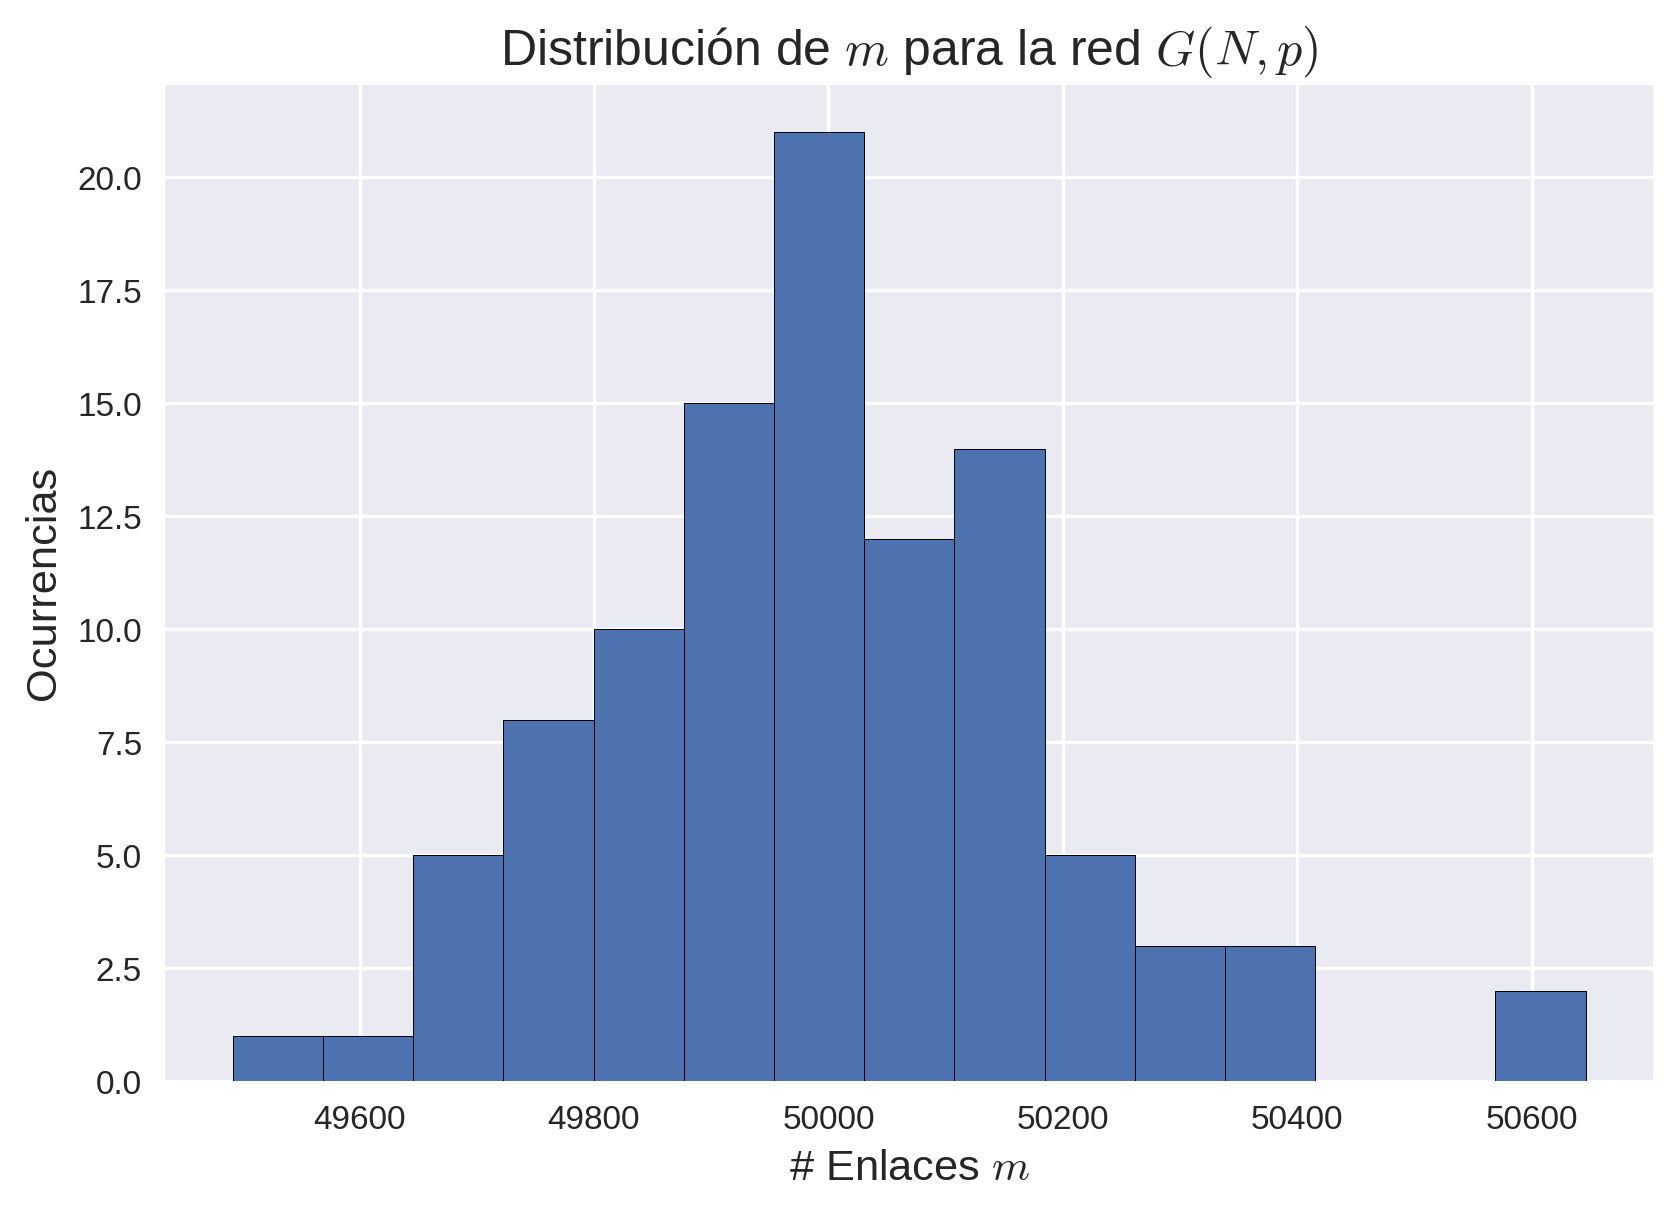

In [23]:
plt.hist(m_vals, bins=15, ec='k')
plt.xlabel("# Enlaces $m$", fontsize=13)
plt.ylabel("Ocurrencias", fontsize=13)
plt.title("Distribución de $m$ para la red $G(N, p)$", fontsize=15)
plt.show()

# 2) Red aleatoria $G(N, k_0)$

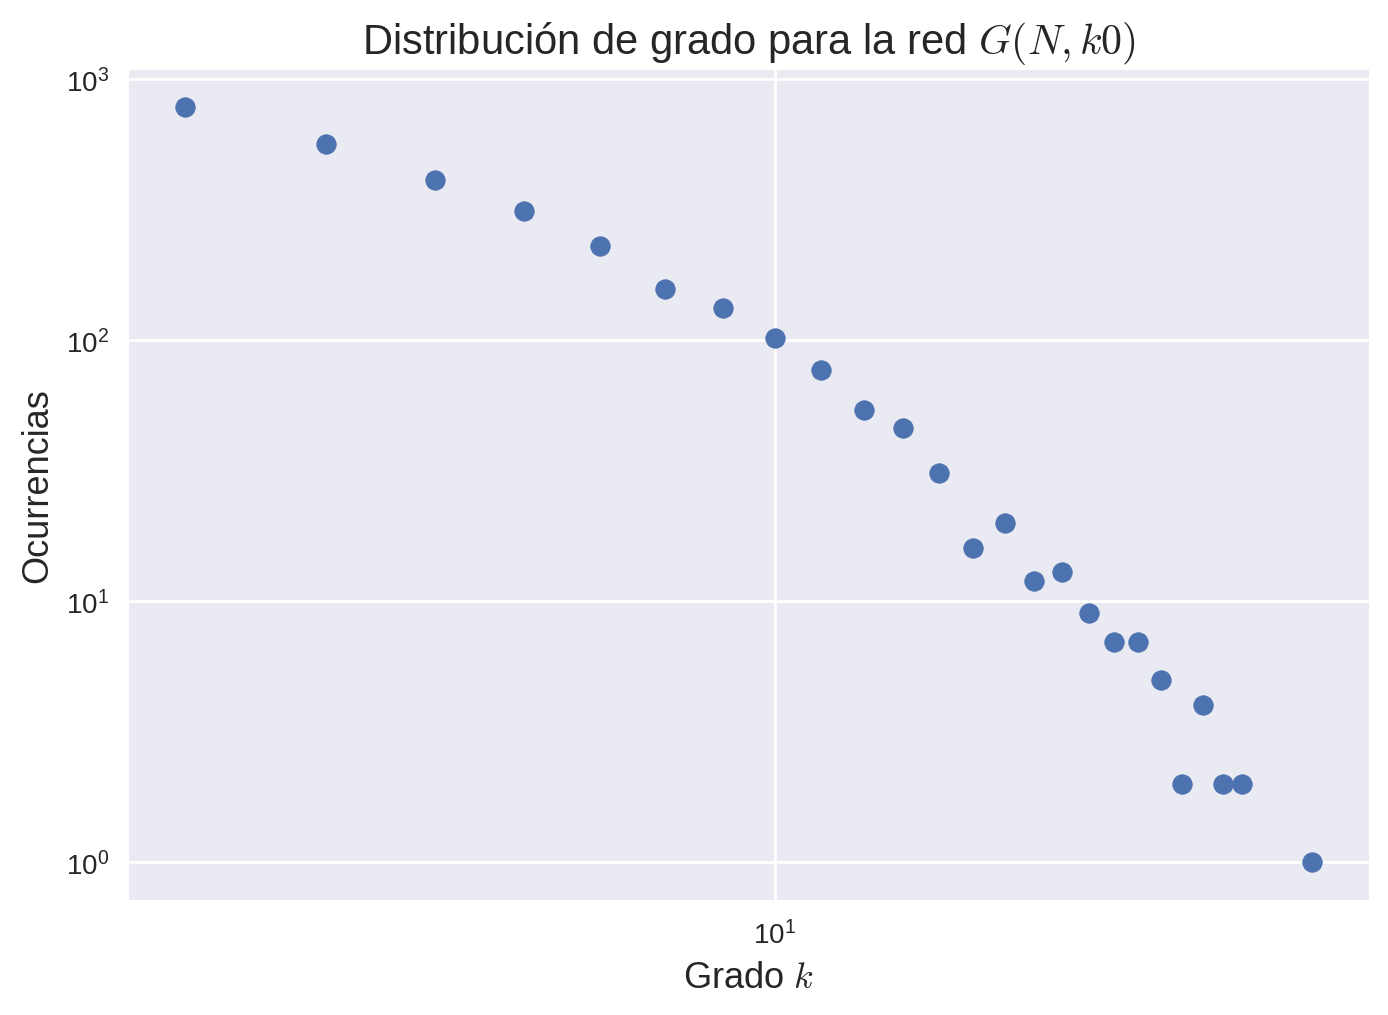

In [59]:
def random_k0_graph(n: int, k0: int) -> nx.Graph:
    """
    Builds a random network with a N nodes and initial k0 degree.
    """
    from random import sample

    #Chequeo de valores.
    if not isinstance(n, int):
        raise TypeError("n should be a int value.")
    if not isinstance(k0, int):
        raise TypeError("k0 should be a int value.")
    if n < k0 + 1:
        raise ValueError("n should be greather than k0 + 1.")
    
    nodes = list(range(k0+1))  # ids

    # Creación incremental de enlaces
    edges = []
    for n1 in nodes:
        # range desde n1+1 porque a medida que n1 aumenta, 
        # nos aseguramos n1 enlaces en los otros ya.
        edges += [(n1, n2) for n2 in range(n1 + 1, max(nodes) + 1)]

    G = nx.Graph(edges)
    # Agregamos nodos hasta la etiqueta n-1.
    for node in range(k0 + 1, n):
        # Elegimos aleatoriamente k0 nodos a los que nos vamos a enlazar.
        targets = sample(nodes, k0)
        # Agregamos a la lista de nodos el nuevo.
        nodes.append(node)
        # Y a la red el nodo y los k0 enlaces.
        G.add_node(node)
        G.add_edges_from([(node, t) for t in targets])

    return G

G = random_k0_graph(3000, 3)

# nx.draw(G, **CUSTOM_FORMAT)
# plt.show()

# Plot de la distribución de grados de este tipo de red.
degrees = dict(G.degree())
degrees_dist = Counter(degrees.values())
plt.scatter(degrees_dist.keys(), degrees_dist.values())
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Grado $k$", fontsize=13)
plt.ylabel("Ocurrencias", fontsize=13)
plt.title("Distribución de grado para la red $G(N, k0)$", fontsize=15)
plt.show()


# 3) Red Barabasi $\hat{G}(N, k_0)$

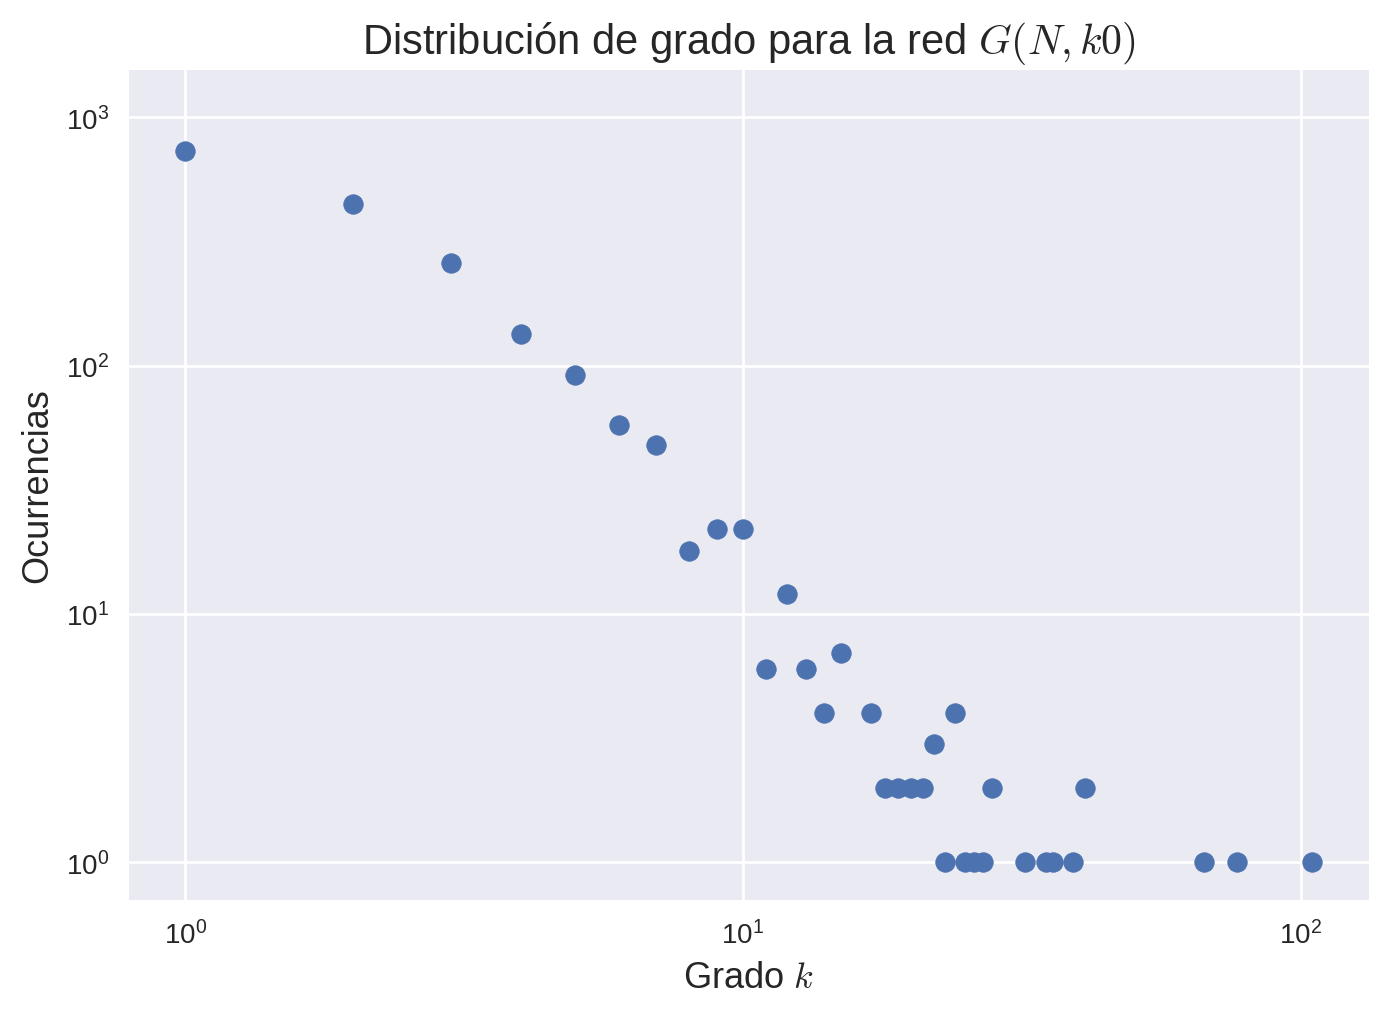

In [60]:
def random_k0_graph(n: int, k0: int) -> nx.Graph:
    """
    Builds a random network with a N nodes and initial k0 degree.
    """
    from random import sample

    #Chequeo de valores.
    if not isinstance(n, int):
        raise TypeError("n should be a int value.")
    if not isinstance(k0, int):
        raise TypeError("k0 should be a int value.")
    if n < k0 + 1:
        raise ValueError("n should be greather than k0 + 1.")
    
    nodes = list(range(k0+1))  # ids

    # Creación incremental de enlaces
    edges = []
    for n1 in nodes:
        # range desde n1+1 porque a medida que n1 aumenta, 
        # nos aseguramos n1 enlaces en los otros ya.
        edges += [(n1, n2) for n2 in range(n1 + 1, max(nodes) + 1)]

    G = nx.Graph(edges)
    # Agregamos nodos hasta la etiqueta n-1.
    for node in range(k0 + 1, n):
        # Elegimos aleatoriamente k0 nodos a los que nos vamos a enlazar.
        rand_vec = np.random.random((len(nodes), 1))
        k_vec = nx.to_numpy_array(G)@np.ones_like(rand_vec)  # grado vector
        p_vec = k_vec/np.sum(k_vec)
        link_to = (rand_vec < p_vec)
        # Agregamos a la lista de nodos el nuevo.
        nodes.append(node)
        # Y a la red el nodo y los k0 enlaces.
        G.add_node(node)
        G.add_edges_from([(node, i) for i, t in enumerate(link_to) if t])

    return G

G = random_k0_graph(3000, 3)

# nx.draw(G, **CUSTOM_FORMAT)
# plt.show()

# Plot de la distribución de grados de este tipo de red.
degrees = dict(G.degree())
degrees_dist = Counter(degrees.values())
plt.scatter(degrees_dist.keys(), degrees_dist.values())
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Grado $k$", fontsize=13)
plt.ylabel("Ocurrencias", fontsize=13)
plt.title("Distribución de grado para la red $G(N, k0)$", fontsize=15)
plt.show()
